# BRKCCT-2510

#### Credit note: some code and pre-processed data has been addopted from [here](https://www.kaggle.com/cguzman09/extracting-emails-from-enron-data-set/notebook).

## Import libraries

In [192]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

from tqdm import tqdm
import collections as cl

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


# Enron Data Filtering

## 1. Email ID as index and raw email content as a the only column


In [2]:
# Download emails.csv from 
# https://www.kaggle.com/cguzman09/extracting-emails-from-enron-data-set/data

emails_df = pd.read_csv('./emails.csv')
print(emails_df.shape)

(517401, 2)


## 2. Separating raw email content into fields

In [3]:
## Helper functions
def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

In [6]:
# Parse the emails into a list email objects
messages = list(map(email.message_from_string, emails_df['message']))
emails_df.drop('message', axis=1, inplace=True)
# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    emails_df[key] = [doc[key] for doc in messages]
# Parse content from emails
emails_df['content'] = list(map(get_text_from_email, messages))
# Split multiple email addresses
emails_df['From'] = emails_df['From'].map(split_email_addresses)
emails_df['To'] = emails_df['To'].map(split_email_addresses)

# Extract the root of 'file' as 'user'
emails_df['user'] = emails_df['file'].map(lambda x:x.split('/')[0])
del messages

In [7]:
# Set index and drop columns with two few values
emails_df = emails_df.set_index('Message-ID')\
    .drop(['file', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding'], axis=1)
# Parse datetime
emails_df['Date'] = pd.to_datetime(emails_df['Date'], infer_datetime_format=True)

In [ ]:

## 3. Filter emails between external and internal addresses, removing garbage


In [105]:
FORBIDEN_EMAIL_NAMES = ['exchangeinfo', 'info', 'noreply', 'newsletter', 'mailbot', 
                        'venturewire', 'messenger', 'alerts-breakingnews', 
                        'continental_airlines_inc', 'memberservices', 'webmaster',
                       'subscriptions', 'Itsimazing', 'Edelivery', 'Winnerannouncements',
                       'enron_update', 'listservices', 'eservices', 'postmaster',
                       'editor', 'dailyquote', 'client', 'knowledge', 'yild', 
                        'anchordesk_daily', 'cbpres', 'edelivery', 'showtimes',
                       'bmg_support', 'gift', 'gifts', 'book-news', 'online.service',
                       'orders','customers', 'auto-confirm', 'special-offers-help',
                       'announce-list', 'bushnews', 'holiday2','radioamerica.org',
                        'thanks', 'exclusive_ofers', 'store-news', 'news', 
                        'annualconference', 'customerservice', 'wincache', 'investorplace',
                       'sweepsclub', 'visitornews', 'orderdetails', 'orderwatch',
                        'member.services', 'announcements', 'enron', 'cigar-admin',
                       'ecenter', 'reservations', 'registration', 'video', 'fantsup',
                       'ftd.com', 'emailclub', 's2u2.com', 'support', 'thehotwire', 'no-reply',
                       'account-update', 'deals', 'hot-farealert', 'onlinebill',
                        'exclusive_offers', 'partner-news', 'articles-email', 'epao', 
                        'software', 'cpa','wise.counsel', 'mailer-daemon', 'pgranoff',
                       'generalinfo']


FORBIDEN_EMAIL_DOMAINS = ['lists.postmastergeneral.com', 'news.forbesdigital.com',
                          'mailman.enron.com', 'replycentral.com', 'lists.autoweb.com',
                         'response.etracks.com', 'open2win.oi3.net', 'info.citibankcards.com',
                         'open2win.roi1.net', 'multexinvestornetwork.com', 'networkpromotion.com',
                         'ombramarketing.com', 'info.iwon.com', 'autotoolbox.net', 'wsj.com',
                         'nytimes.com', 'enews.buy.com', 'mta04.optamail.com', 'mta10.optamail.com',
                         'mail3.travelocity.com', 'mail3.travelocity.com', 'investorplace.com',
                         'www0.humornetwork.com', '1.americanexpress.com', 'sweepsclub.com',
                         'edgar-online.com', 'paypal.com', 'buy.com', 'airmail.continental.com',
                         'xmr3.com', 'ebay.com', 'kc-mx.avantgo.com', 'ipgdirect.com',
                         'energynewslive.com' 'georgewbush.com', 'sportsline.com', 'cmates.com',
                         'ameritrade.customer-email.com', 'shop2u.com', 'interchange-energy.com',
                         '1800flowers.com', 'radioamerica.org', 'ix.netcom.com', 
                          'meals.alazing.com', 'offer.omahasteaks.com', 'mailfromftd.com', 
                          'pge.com', 'enerfax.com']


def isEmailValid(email):
    try:
        if re.search(r'\b[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,}\b', email, re.I).group() == email: 
            email_name, email_domain = email.split("@")
            if email_name not in FORBIDEN_EMAIL_NAMES and email_domain not in FORBIDEN_EMAIL_DOMAINS:
                return True
            else:
                return False
        else:
            return False            
    except Exception as e:
        return False
    
def isEmailDomainOrName(email,domain_or_name, text):
    try:
        parts = email.split("@")
        if domain_or_name == 'name':
            if parts[0] == text:
                return True
            else:
                return False
        elif domain_or_name == 'domain':
            if parts[1] == text:                
                return True
            else:
                return False
        else:
            raise ValueError('Worng parameter value in function isEmailDomainOrName.')                                  
    except Exception as e:
        return False

def isEnronEmailAddrress(address_fs):
    for address in address_fs:
        if isEmailValid(address):
            if isEmailDomainOrName(address,'domain', "enron.com"): 
                return "enron"
            else:
                return "external"
        else:
            return "invalid"

def isEnronEmail_101(row):
    if isinstance(row['To'], frozenset) and len(row['To']) == 1:
        addr_to = isEnronEmailAddrress(row['To'])
    else:
        return False
    if isinstance(row['From'], frozenset) and len(row['From']) == 1:
        addr_from = isEnronEmailAddrress(row['From'])
    else:
        return False
    if (addr_to == "enron" and addr_from == "external") or (addr_from == "enron" and addr_to == "external"):
        return True
    else:
        return False

In [167]:
print("Dataset before filtering {}".format(emails_df.shape))
emails_101_df = pd.DataFrame(emails_df[emails_df.apply(lambda row: isEnronEmail_101(row), axis=1)])


Dataset before filtering (517401, 13)
New dataset after filtering (89756, 5)



## 4. Remove unused fields


In [108]:
emails_101_df=emails_101_df[['From', 'To', 'Date', 'Subject','content']].dropna().copy()
print("New dataset after filtering {}".format(emails_101_df.shape))


(89756, 5)


## 5. Additionally filter only emails with replies

In [175]:
emails_sent = {}
emails_pared = {}
Email = cl.namedtuple('Email', ['Email1', 'Email2', 'Subject'])

def discover_replied_emails( email1, email2, subject):   
    email_tuple_1 = email1, email2, subject
    email_event_1 = Email._make(email_tuple_1)
    email_tuple_2 = email2, email1, subject
    email_event_2 = Email._make(email_tuple_2)
    if email_event_2 in emails_sent:
        if not email_event_1 in emails_pared:
            emails_pared[email_event_1] = 1
            emails_pared[email_event_2] = 1
        else:
            emails_pared[email_event_1] +=1
            emails_pared[email_event_2] +=1
            
    elif not email_event_1 in emails_sent:
        emails_sent[email_event_1] = 1
    else:
        emails_sent[email_event_1] += 1
        
def clean_subject(subject):
    if subject.startswith("Re: ") or subject.startswith("RE: "):
        return clean_subject(subject[4:])
    elif  subject.startswith("Re:") or subject.startswith("RE:"):
        return clean_subject(subject[3:])
    return subject 

def are_emails_pared(email1, email2, subject):   
    email_tuple = email1, email2, subject
    email_event = Email._make(email_tuple)
    if email_event in emails_pared:
        return True
    else:
        return False
    
def are_emails_pared_row(row): 
    email1 = next(iter(row['To']))
    email2 = next(iter(row['From']))
    subject = clean_subject(row['Subject'])
    if not subject == "":
        if are_emails_pared(email1, email2, subject):
            return True
    return False


In [176]:
emails_sent = {}
emails_pared = {}
with tqdm(total=emails_101_df.shape[0]) as pbar:
    for idx, eMailToProcess in emails_101_df.iterrows():
        #print('Row idx:{}, From: {}, To: {}, Subject {} '.format(idx, next(iter(eMailToProcess['To'])), next(iter(eMailToProcess['From'])),eMailToProcess['Subject']))    
        email1 = next(iter(eMailToProcess['To']))
        email2 = next(iter(eMailToProcess['From']))
        subject = clean_subject(eMailToProcess['Subject'])
        if not subject == "":
            #print("Final subject: {}".format(subject))
            discover_replied_emails( email1, email2, subject)  
        pbar.update()
    pbar.close()
print("Emails sent: {}, emails pared with replies: {}".format(len(emails_sent), len(emails_pared)))

100%|██████████| 89756/89756 [00:07<00:00, 12156.24it/s]

Emails sent: 33003, emails pared with replies: 4348


In [177]:
print("Dataset before filtering {}".format(emails_101_df.shape))

emails_CC_df = pd.DataFrame(emails_101_df[emails_101_df.apply(lambda row: are_emails_pared_row(row), axis=1)])
print("New dataset after filtering {}".format(emails_CC_df.shape))

Dataset before filtering (89756, 5)
New dataset after filtering (11632, 5)



## 6. Separating train and test data

In [181]:
train_df = emails_CC_df.sample(frac=0.95,random_state=200)
test_df=emails_CC_df.drop(train_df.index)

In [459]:
# test_df.shape

(582, 5)

# Building LDA Model

 
## 1. Cleaning text from new lines, emails, single quotas, etc.  

In [461]:
## Remove emails and newline characters

# Convert to list
data = train_df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

# pprint(data[:1])

['Yo baby whats up? Thanks for hanging out with me on Monday night. I had a '
 'really good time (even if you were preoccupied with the Dave thing). I hope '
 'all is going well for you. I am actually working a day shift which is pretty '
 'cool because there is a lot less to do on the day shifts. So, what do you '
 'have going for the rest of the week? I have a work function tonight. One of '
 'my friends is moving to the Calgary office so we are all going for beers at '
 'the Lucky Lab in southeast. I got a call from my date from hell. Aparently I '
 'told her last week that we could grab a movie tonight. I dont want to go so '
 'I think I am just going to tell her that this work thing is going to last '
 'too late. Anyway how is your grandmother doing? Are you excited about your '
 'party this weekend? I went and bought a couple dress shirts and a tie for my '
 'christmas party at Nordstrom yesterday and ended up spending $184 ! Just on '
 'two shirts and a tie. I should just refrai

## 2. Tokenize words

In [462]:
## Tokenize words and Clean-up text

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

# print(data_words[:1])

[['yo', 'baby', 'whats', 'up', 'thanks', 'for', 'hanging', 'out', 'with', 'me', 'on', 'monday', 'night', 'had', 'really', 'good', 'time', 'even', 'if', 'you', 'were', 'preoccupied', 'with', 'the', 'dave', 'thing', 'hope', 'all', 'is', 'going', 'well', 'for', 'you', 'am', 'actually', 'working', 'day', 'shift', 'which', 'is', 'pretty', 'cool', 'because', 'there', 'is', 'lot', 'less', 'to', 'do', 'on', 'the', 'day', 'shifts', 'so', 'what', 'do', 'you', 'have', 'going', 'for', 'the', 'rest', 'of', 'the', 'week', 'have', 'work', 'function', 'tonight', 'one', 'of', 'my', 'friends', 'is', 'moving', 'to', 'the', 'calgary', 'office', 'so', 'we', 'are', 'all', 'going', 'for', 'beers', 'at', 'the', 'lucky', 'lab', 'in', 'southeast', 'got', 'call', 'from', 'my', 'date', 'from', 'hell', 'aparently', 'told', 'her', 'last', 'week', 'that', 'we', 'could', 'grab', 'movie', 'tonight', 'dont', 'want', 'to', 'go', 'so', 'think', 'am', 'just', 'going', 'to', 'tell', 'her', 'that', 'this', 'work', 'thing', 

## 3. Creating bigrams and trigrams

In paragraphs, certain words always tend to occur in pairs (bigram) or in groups of threes (trigram). 

Because the two words combined together form the actual entity. 

For example: The word ‘French’ refers the language or region and the word ‘revolution’ can refer to the planetary revolution. 
    
But combining them, ‘French Revolution’, refers to something completely different


In [463]:

## Creating Bigram and Trigram Models

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.                          
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
# print(trigram_mod[bigram_mod[data_words[0]]])

['yo', 'baby', 'whats', 'up', 'thanks', 'for', 'hanging', 'out', 'with', 'me', 'on', 'monday', 'night', 'had', 'really', 'good', 'time', 'even', 'if', 'you', 'were', 'preoccupied', 'with', 'the', 'dave', 'thing', 'hope', 'all', 'is', 'going', 'well', 'for', 'you', 'am', 'actually', 'working', 'day', 'shift', 'which', 'is', 'pretty', 'cool', 'because', 'there', 'is', 'lot', 'less', 'to', 'do', 'on', 'the', 'day', 'shifts', 'so', 'what', 'do', 'you', 'have', 'going', 'for', 'the', 'rest', 'of', 'the', 'week', 'have', 'work', 'function', 'tonight', 'one', 'of', 'my', 'friends', 'is', 'moving', 'to', 'the', 'calgary', 'office', 'so', 'we', 'are', 'all', 'going', 'for', 'beers', 'at', 'the', 'lucky', 'lab', 'in', 'southeast', 'got', 'call', 'from', 'my', 'date', 'from', 'hell', 'aparently', 'told', 'her', 'last', 'week', 'that', 'we', 'could', 'grab', 'movie', 'tonight', 'dont', 'want', 'to', 'go', 'so', 'think', 'am', 'just', 'going', 'to', 'tell', 'her', 'that', 'this', 'work', 'thing', '

In [418]:
# print(trigram_mod[bigram_mod[data_words[5]]])

['you', 'are', 'funny', 'laughed', 'for', 'min', 'when', 'saw', 'this', 'veselack_joni', 'on', 'pm', 'to', 'cc', 'subject', 're', 'bbq_jonis_sendoff_sunday', 'sept', 'th', 'pm', 'may', 'need', 'you', 'to', 'help', 'turn', 'the', 'chicks', 'you', 'guess', 'which', 'kind', 'original', 'message', 'from', 'sent', 'tuesday', 'september', 'pm', 'to', 'subject', 're', 'bbq_jonis_sendoff_sunday', 'sept', 'th', 'pm', 'im', 'there', 'veselack_joni', 'on', 'pm', 'to', 'baker_briant_bowen_tricia', 'campos_alma_chastain_renee', 'chokshi_collins_joann_cooper', 'audrey_dempsey_rhonda_gallagher', 'lisa', 'germany_chris_klein_mary', 'kolosseus_mike_la_madrid', 'victor_landry_chad_luby', 'patrick_luis_michelle_mehra', 'ziba_mitchell_meredith_olinger', 'kim_preuss_byron_scherwitz', 'scot_shelton_carolyn', 'sumrow_chris', 'sumrow_molly_vachuska_cindy', 'vigil_gene_wagner_cassandra', 'wagner_ross_williams', 'sean_frnka_dawn_bienski', 'janet', 'cc', 'subject', 'bbq_jonis_sendoff_sunday', 'sept', 'th', 'pm',

## 4. Use lemmatization to filter only nouns, adjectives, verbs and adverbs and remove stop words


In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'go', 'get', 'not', 'be', 'know', 'good',
                  'do', 'think', 'would', 'see', 'pm', 'want', 'send', 'work', 'time', 'call', 's',
                  'day', 'week', 'let', 'may', 'come', 'look', 'well', 'take', 'back', 'phone',
                  'need', 'make', 'also', 'pron'])

In [464]:
## Remove Stopwords, Make Bigrams and Lemmatize

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [465]:


# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Form Trigrams
data_words_trigrams = make_trigrams(data_words_bigrams)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Remove Stop Words
data_words_final = remove_stopwords(data_lemmatized)

# print(data_words_final[:1])

[['baby', 'thank', 'hang', 'night', 'really', 'even', 'preoccupy', 'dave', 'thing', 'hope', 'actually', 'shift', 'pretty', 'cool', 'lot', 'less', 'shift', 'rest', 'function', 'tonight', 'friend', 'move', 'calgary', 'office', 'beer', 'lucky', 'lab', 'southeast', 'date', 'hell', 'aparently', 'tell', 'last', 'could', 'grab', 'movie', 'tonight', 'tell', 'thing', 'last', 'late', 'grandmother', 'excited', 'party', 'weekend', 'buy', 'couple', 'dress', 'shirt', 'tie', 'christma', 'party', 'nordstrom', 'yesterday', 'end', 'spend', 'shirt', 'tie', 'refrain', 'even', 'store', 'check', 'later', 'sweetie']]


## 5. Create Dictionary and Corpus

In order to work on text documents, Gensim requires the words (tokens) be converted to unique IDs

In order to achieve that, Gensim lets you create a Dictionary object that maps each word to a unique ID

So, how to create a `Dictionary`? By converting your text/sentences to a [list of words] and pass it to the corpora.Dictionary() object.

The dictionary object is typically used to create a ‘bag of words’ Corpus. It is this Dictionary and the bag-of-words (Corpus) that are used as inputs to topic modeling and other models that Gensim specializes in.

The next important object you need to familiarize with in order to work in gensim is the Corpus (a Bag of Words).

That is, it is a corpus object that contains the word id and its frequency in each document. 

You can think of it as gensim’s equivalent of a Document-Term matrix.

Once you have the updated dictionary, all you need to do to create a bag of words corpus is to pass the tokenized list of words to the Dictionary.doc2bow()



In [466]:
## Create the Dictionary and Corpus needed for Topic Modeling

# Create Dictionary
id2word = corpora.Dictionary(data_words_final)

# Create Corpus
texts = data_words_final

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
# print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 2), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 2), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 2), (43, 2), (44, 1), (45, 1), (46, 1), (47, 1), (48, 2), (49, 1), (50, 2), (51, 2), (52, 2), (53, 1), (54, 1)]]


In [426]:
# Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[5:6]]

[[('buy', 3),
  ('last', 1),
  ('party', 2),
  ('pron', 3),
  ('name', 2),
  ('cc', 1),
  ('fire', 1),
  ('message', 1),
  ('order', 2),
  ('original', 1),
  ('company', 8),
  ('product', 2),
  ('bbq', 3),
  ('bring', 1),
  ('california', 2),
  ('chick', 1),
  ('continue', 2),
  ('customer', 2),
  ('decide', 1),
  ('definitely', 1),
  ('dessert', 1),
  ('electric', 4),
  ('energy', 1),
  ('enjoy', 1),
  ('farewell', 1),
  ('funny', 1),
  ('grill', 1),
  ('group', 4),
  ('guess', 1),
  ('gutter', 1),
  ('head', 1),
  ('head_count', 1),
  ('help', 1),
  ('janet', 1),
  ('joni_veselack', 1),
  ('kind', 1),
  ('laugh', 1),
  ('leave', 1),
  ('lisa', 1),
  ('logo', 2),
  ('min', 1),
  ('mind', 1),
  ('much', 1),
  ('north', 1),
  ('own_cheer', 1),
  ('pacific_gas', 4),
  ('pg', 2),
  ('place', 1),
  ('pool', 1),
  ('public', 2),
  ('regulate', 2),
  ('regulated', 2),
  ('sept', 3),
  ('september', 2),
  ('service', 2),
  ('side_dish', 1),
  ('snacks_along', 1),
  ('sumrow_chris', 1),
  ('su

## 6. Create the model and find the optimal number of topics


In [499]:
## How to find the optimal number of topics for LDA?

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    perplexity_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)        
        model_list.append(model)
                
        # Compute Perplexity
        # a measure of how good the model is. lower the better.
        perplexity_values.append(model.log_perplexity(corpus))
        
        # Compute Coherence Score
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, perplexity_values, coherence_values

In [500]:
# Can take a long time to run.
model_list, perplexity_values, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=40, step=1)

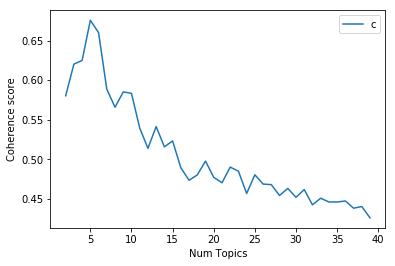

In [501]:
# Show graph
limit=40; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [536]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model_list[3], corpus, id2word) # Num of topic 5 was done for model_list[3]

In [542]:

vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.103653 -0.022882       1        1  20.204142
1      0.271152 -0.181834       2        1  21.372717
2     -0.259359 -0.126725       3        1  12.442656
3      0.054888  0.101108       4        1  19.970949
4      0.036972  0.230333       5        1  26.009533, topic_info=     Category          Freq            Term         Total  loglift  logprob
term                                                                       
259   Default   4846.000000            rely   4846.000000  30.0000  30.0000
91    Default   5508.000000            kent   5508.000000  29.0000  29.0000
164   Default  10537.000000             mir  10537.000000  28.0000  28.0000
235   Default   9584.000000        estoppel   9584.000000  27.0000  27.0000
59    Default   4290.000000     appropriate   4290.000000  26.0000  26.0000
226   Default   4443.000000          create   4443.000000  25.0000  25.0000
163   Default   7573.000000         message   7573.000000  24.0000  24.0000
522   Default   3381.000000          fabian   3381.000000  23.0000  23.0000
72    Default   3903.000000      contractor   3903.000000  22.0000  22.0000
171   Default   6701.000000         predict   6701.000000  21.0000  21.0000
832   Default   2958.000000      clause_par   2958.000000  20.0000  20.0000
39    Default  30259.000000          really  30259.000000  19.0000  19.0000
138   Default   2364.000000         contain   2364.000000  18.0000  18.0000
50    Default   8348.000000           thing   8348.000000  17.0000  17.0000
1268  Default   2872.000000         powerex   2872.000000  16.0000  16.0000
113   Default   3439.000000          regard   3439.000000  15.0000  15.0000
179   Default   1988.000000        thursday   1988.000000  14.0000  14.0000
74    Default   3006.000000            cost   3006.000000  13.0000  13.0000
139   Default   1991.000000          delete   1991.000000  12.0000  12.0000
140   Default   2073.000000        delivery   2073.000000  11.0000  11.0000
229   Default   1318.000000           drive   1318.000000  10.0000  10.0000
173   Default   1785.000000     proprietary   1785.000000   9.0000   9.0000
246   Default   1300.000000        minimize   1300.000000   8.0000   8.0000
262   Default   2383.000000     richey_coop   2383.000000   7.0000   7.0000
1270  Default   2316.000000    price_gouger   2316.000000   6.0000   6.0000
80    Default   3485.000000        february   3485.000000   5.0000   5.0000
158   Default   1539.000000     keffer_john   1539.000000   4.0000   4.0000
224   Default   2319.000000           corel   2319.000000   3.0000   3.0000
284   Default   2967.000000           enjoy   2967.000000   2.0000   2.0000
261   Default   1469.000000          review   1469.000000   1.0000   1.0000
...       ...           ...             ...           ...      ...      ...
621    Topic5    880.520630            mine    943.662598   1.2774  -5.5398
1525   Topic5    448.322052            tara    461.129700   1.3185  -6.2148
38     Topic5    580.226501          pretty    611.488037   1.2942  -5.9569
85     Topic5   1509.098999            home   1752.479980   1.1972  -5.0010
290    Topic5    414.790802          gutter    424.799530   1.3228  -6.2925
49     Topic5   1118.992432           thank   1297.797852   1.1984  -5.3001
299    Topic5   1087.396484            lisa   1288.253296   1.1772  -5.3288
514    Topic5   1275.634888          though   1670.031982   1.0773  -5.1691
23     Topic5   1450.983521            hope   1985.445801   1.0331  -5.0403
39     Topic5  12165.500000          really  30259.666016   0.4355  -2.9140
538    Topic5   1254.326294     instruction   1748.313232   1.0146  -5.1860
656    Topic5   1344.213257             tax   1944.076416   0.9777  -5.1168
51     Topic5   1030.226929             tie   1369.685181   1.0619  -5.3828
605    Topic5   1132.377686            hook   1714.717285   0.9318  -5.2882
273    

## 7. Save the model to files


In [482]:
import json

def save_model_to_files(model, bigram_mod, trigram_mod, file_name, path, coherence_score, model_type, vis):
    full_file_name = path + '/' + file_name
    json_file_name = full_file_name + '.json'
    bigram_file_name = full_file_name + '.bigram'
    trigram_file_name = full_file_name + '.trigram'
    pyLDAviz_web_page = full_file_name + '.html'
    model.save(full_file_name)
    bigram_mod.save(bigram_file_name)
    trigram_mod.save(trigram_file_name)
    pyLDAvis.save_html(vis, pyLDAviz_web_page)
    with open(json_file_name , 'w') as outfile:
        json.dump({'model_type': model_type, 'number_of_topics': 5, 'coherence_score': coherence_score}, outfile, ensure_ascii=False)
    print("Model saved to files {}*".format(full_file_name))
      
def save_test_data_to_files(df, path, prefix):
    row_number = 1
    for idx, row in df.iterrows():
        full_file_name = path + "/" + prefix + "_" + str(row_number) + ".txt"
        with open(full_file_name , 'w') as outfile:
            outfile.write(row['content'])
            outfile.close()
        row_number += 1

In [483]:
save_model_to_files(model_list[3], bigram_mod, trigram_mod, "ENRON_CC_V4", "./models", 0.6755, "LDA", vis)

Model saved to files ./models/ENRON_CC_V4*


## 8. Test the model

In [521]:
HOST_NAME = "3.121.213.222.xip.io"
import requests

def test_file(file_name, model_id):
    f = open(file_name, "r")
    data = f.read()
    f.close()
    r = requests.post("http://" + HOST_NAME + "/model/"+ str(model_id) + "/inference_text", data=data,  headers={'Content-Type': 'text/plain;charset=UTF-8'})
    distributions = r.json()['Inference'][0]['Distribution']
    result = {}
    for distribution in distributions:
        print("Topic number: {}, distribution: {}, rank: {}".format(distribution['topic_number'], distribution['distribution'], distribution['rank'] ))
        if distribution['rank'] == 1:
            result['topic_number'] = distribution['topic_number']
            result['distribution'] =distribution['distribution']
            result['text_size'] = len(data)
            return result


In [491]:
results = {}
path = './ENRON_CC_TEST'
with tqdm(total=582) as pbar:
    for file_name in os.listdir(path):
        current = os.path.join(path, file_name)
        if os.path.isfile(current):
            results[file_name] = test_file(current, 2)
            pbar.update()
    pbar.close()

result_df=pd.DataFrame(results)
print(result_df.shape)
result_df.head()

100%|██████████| 582/582 [06:05<00:00,  1.65it/s]


(3, 582)


,Test_76.txt,Test_62.txt,Test_111.txt,Test_89.txt,Test_105.txt,Test_139.txt,Test_475.txt,Test_313.txt,Test_307.txt,Test_461.txt,...,Test_478.txt,Test_487.txt,Test_493.txt,Test_120.txt,Test_134.txt,Test_84.txt,Test_90.txt,Test_108.txt,Test_47.txt,Test_53.txt
distribution,0.656462,0.481299,0.697551,0.485713,0.835515,0.526173,0.569515,0.905141,0.729004,0.411093,...,0.903767,0.667142,0.559949,0.490229,0.578077,0.54984,0.816782,0.872425,0.683712,0.534103
text_size,609.000000,4510.000000,170.000000,788.000000,794.000000,7460.000000,1250.000000,1129.000000,829.000000,2796.000000,...,114.000000,597.000000,319.000000,1671.000000,162.000000,250.00000,227.000000,247.000000,13.000000,487.000000
topic_number,4.000000,4.000000,4.000000,4.000000,1.000000,3.000000,5.000000,1.000000,1.000000,1.000000,...,5.000000,5.000000,4.000000,2.000000,4.000000,4.00000,4.000000,4.000000,4.000000,5.000000


In [494]:
res_df = result_df.transpose()

In [495]:
res_df.head()

,distribution,text_size,topic_number
Test_76.txt,0.656462,609.0,4.0
Test_62.txt,0.481299,4510.0,4.0
Test_111.txt,0.697551,170.0,4.0
Test_89.txt,0.485713,788.0,4.0
Test_105.txt,0.835515,794.0,1.0


In [497]:
res_df['distribution'].describe()

count    582.000000
mean       0.686451
std        0.177697
min        0.288524
25%        0.532028
50%        0.692107
75%        0.837048
max        0.985977
Name: distribution, dtype: float64

In [498]:
res_df['distribution'].corr(res_df['text_size'])

-0.14431037484556464